**Avoid Using pip install with GPUs and TPUs**

> We recommend against using pip install to specify a particular TensorFlow version for both GPU and TPU backends. Colab builds TensorFlow from source to ensure compatibility with our fleet of accelerators. Versions of TensorFlow fetched from PyPI by pip may suffer from performance problems or may not work at all.






In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Input,Attention,Bidirectional, Conv1D, MaxPooling1D, Flatten, GRU
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
#from attention import Attention
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate
from tensorflow.keras.layers import Layer
from keras.regularizers import l2


In [2]:
#%tensorflow_version 2.6
print(tf.__version__)

2.8.0


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# define filepath to read data
dir_path = '/content/gdrive/MyDrive/DL_Data/CMAPSSData/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_target = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])




# inspect first few rows
print(train.head())
print(test.head())
print(y_target)

   unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    -0.0007    -0.0004      100.0  518.67  641.82   
1        1            2     0.0019    -0.0003      100.0  518.67  642.15   
2        1            3    -0.0043     0.0003      100.0  518.67  642.35   
3        1            4     0.0007     0.0000      100.0  518.67  642.35   
4        1            5    -0.0019    -0.0002      100.0  518.67  642.37   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03   392   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03   392   
2  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03   390   
3  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03   392   
4  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03   393   

   s_18   s_19   s_20     s_21  
0  2388  100.0  39.06  

In [5]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
print(train[index_names+['RUL']].head())

test = add_remaining_useful_life(test)
print(test[index_names+['RUL']].head())

   unit_nr  time_cycles  RUL
0        1            1  191
1        1            2  190
2        1            3  189
3        1            4  188
4        1            5  187
   unit_nr  time_cycles  RUL
0        1            1   30
1        1            2   29
2        1            3   28
3        1            4   27
4        1            5   26


In [6]:
sensors_name = ['s_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21']

In [7]:
print(train.iloc[0])
train_unit = train['unit_nr']
train_unit
train_RUL = train['RUL']
columns = train.columns

unit_nr           1.0000
time_cycles       1.0000
setting_1        -0.0007
setting_2        -0.0004
setting_3       100.0000
s_1             518.6700
s_2             641.8200
s_3            1589.7000
s_4            1400.6000
s_5              14.6200
s_6              21.6100
s_7             554.3600
s_8            2388.0600
s_9            9046.1900
s_10              1.3000
s_11             47.4700
s_12            521.6600
s_13           2388.0200
s_14           8138.6200
s_15              8.4195
s_16              0.0300
s_17            392.0000
s_18           2388.0000
s_19            100.0000
s_20             39.0600
s_21             23.4190
RUL             191.0000
Name: 0, dtype: float64


In [8]:
print(test)
test_unit = test['unit_nr']
test_unit
test_RUL = test['RUL']

       unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1            1     0.0023     0.0003      100.0  518.67  643.02   
1            1            2    -0.0027    -0.0003      100.0  518.67  641.71   
2            1            3     0.0003     0.0001      100.0  518.67  642.46   
3            1            4     0.0042     0.0000      100.0  518.67  642.44   
4            1            5     0.0014     0.0000      100.0  518.67  642.51   
...        ...          ...        ...        ...        ...     ...     ...   
13091      100          194     0.0049     0.0000      100.0  518.67  643.24   
13092      100          195    -0.0011    -0.0001      100.0  518.67  643.22   
13093      100          196    -0.0006    -0.0003      100.0  518.67  643.44   
13094      100          197    -0.0038     0.0001      100.0  518.67  643.26   
13095      100          198     0.0013     0.0003      100.0  518.67  642.95   

           s_3      s_4    s_5  ...    

In [9]:
test

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,4
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,3
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,2
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,1


In [10]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))

#scaler = MinMaxScaler()
normalized_train = pd.DataFrame(min_max_scaler.fit_transform(train.drop(columns = 'RUL')))
normalized_test = pd.DataFrame(min_max_scaler.transform(test.drop(columns = 'RUL')))

#normalized_train = pd.DataFrame(min_max_scaler.fit_transform(train))
#normalized_test = pd.DataFrame(min_max_scaler.transform(test))
#train['RUL'] = scaler.fit_transform(np.asarray(train['RUL']).reshape(-1,1))


In [11]:
normalized_train['RUL'] = train_RUL
normalized_train.columns = columns
normalized_train['unit_nr'] = train_unit
normalized_test['RUL'] = test_RUL
normalized_test.columns = columns
normalized_test['unit_nr'] = test_unit

In [12]:
normalized_train.clip(upper = 125)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,0.000000,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,125
1,1,0.002770,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,125
2,1,0.005540,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,125
3,1,0.008310,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,125
4,1,0.011080,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,0.540166,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,...,0.558824,0.194344,0.656791,0.0,0.750000,0.0,0.0,0.271318,0.109500,4
20627,100,0.542936,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,...,0.500000,0.188668,0.727203,0.0,0.583333,0.0,0.0,0.124031,0.366197,3
20628,100,0.545706,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,...,0.529412,0.212148,0.922278,0.0,0.833333,0.0,0.0,0.232558,0.053991,2
20629,100,0.548476,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,...,0.514706,0.203065,0.823394,0.0,0.583333,0.0,0.0,0.116279,0.234466,1


In [13]:
normalized_test

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,0.000000,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,30
1,1,0.002770,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,29
2,1,0.005540,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,28
3,1,0.008310,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,27
4,1,0.011080,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,0.534626,0.781609,0.500000,0.0,0.0,0.611446,0.619359,0.566172,0.0,...,0.176471,0.584890,0.564063,0.0,0.500000,0.0,0.0,0.395349,0.418669,4
13092,100,0.537396,0.436782,0.416667,0.0,0.0,0.605422,0.537388,0.671843,0.0,...,0.308824,0.572350,0.485956,0.0,0.583333,0.0,0.0,0.333333,0.528721,3
13093,100,0.540166,0.465517,0.250000,0.0,0.0,0.671687,0.482014,0.414754,0.0,...,0.235294,0.605326,0.507888,0.0,0.583333,0.0,0.0,0.372093,0.429301,2
13094,100,0.542936,0.281609,0.583333,0.0,0.0,0.617470,0.522128,0.626435,0.0,...,0.294118,0.622046,0.562524,0.0,0.583333,0.0,0.0,0.403101,0.518779,1


In [14]:
ws = 30
drop_unit = []
unit_sz = []
for i in range(1,101):
  if len(normalized_test[normalized_test['unit_nr']==i]) < ws:
    drop_unit.append(i)

ws_test = normalized_test.drop(normalized_test[normalized_test['unit_nr']==1].index)
for i in drop_unit[1:]:
  ws_test = ws_test.drop(normalized_test[normalized_test['unit_nr']==i].index)

n_test_unit = ws_test['unit_nr'].unique()
unit_test_sz = []
for i in n_test_unit:
  unit_test_sz.append(len(ws_test[ws_test['unit_nr'] == i]))
ws_test

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
31,2,0.000000,0.448276,0.833333,0.0,0.0,0.436747,0.398082,0.420493,0.0,...,0.382353,0.153009,0.397845,0.0,0.333333,0.0,0.0,0.666667,0.687793,48
32,2,0.002770,0.436782,0.666667,0.0,0.0,0.391566,0.379115,0.391965,0.0,...,0.294118,0.103777,0.448249,0.0,0.416667,0.0,0.0,0.542636,0.546810,47
33,2,0.005540,0.511494,0.750000,0.0,0.0,0.412651,0.535426,0.482951,0.0,...,0.294118,0.138353,0.213544,0.0,0.500000,0.0,0.0,0.682171,0.707263,46
34,2,0.008310,0.643678,0.583333,0.0,0.0,0.331325,0.270111,0.438555,0.0,...,0.264706,0.154660,0.420546,0.0,0.416667,0.0,0.0,0.527132,0.794946,45
35,2,0.011080,0.522989,0.166667,0.0,0.0,0.469880,0.304992,0.427920,0.0,...,0.338235,0.139694,0.383994,0.0,0.333333,0.0,0.0,0.519380,0.683927,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,0.534626,0.781609,0.500000,0.0,0.0,0.611446,0.619359,0.566172,0.0,...,0.176471,0.584890,0.564063,0.0,0.500000,0.0,0.0,0.395349,0.418669,4
13092,100,0.537396,0.436782,0.416667,0.0,0.0,0.605422,0.537388,0.671843,0.0,...,0.308824,0.572350,0.485956,0.0,0.583333,0.0,0.0,0.333333,0.528721,3
13093,100,0.540166,0.465517,0.250000,0.0,0.0,0.671687,0.482014,0.414754,0.0,...,0.235294,0.605326,0.507888,0.0,0.583333,0.0,0.0,0.372093,0.429301,2
13094,100,0.542936,0.281609,0.583333,0.0,0.0,0.617470,0.522128,0.626435,0.0,...,0.294118,0.622046,0.562524,0.0,0.583333,0.0,0.0,0.403101,0.518779,1


**Exploring Data**

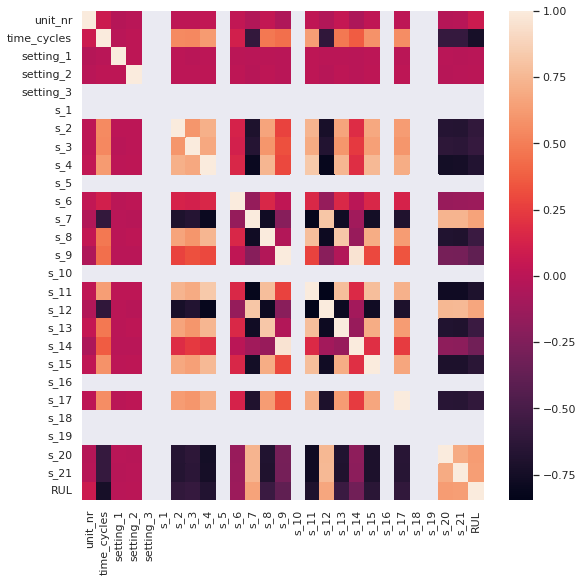

In [15]:
fig, ax = plt.subplots(figsize=(9,9))         # Sample figsize in inches
sns.heatmap(train.corr(), xticklabels=True, yticklabels=True)


            unit_nr   time_cycles
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000
       time_cycles
count   100.000000
mean    206.310000
std      46.342749
min     128.000000
25%     177.000000
50%     199.000000
75%     229.250000
max     362.000000


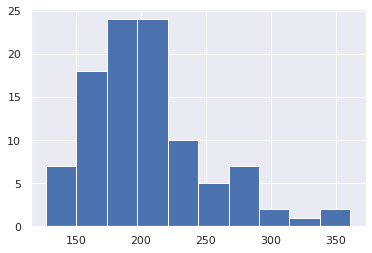

In [16]:
print(train[index_names].describe())
print(train[index_names].groupby('unit_nr').max().describe())
engine_max_RUL = []
for i in range(1,101):
  engine_max_RUL.append(max(train[train['unit_nr'] == i]['RUL']))
plt.hist(engine_max_RUL)
plt.show()

Sensor s_1


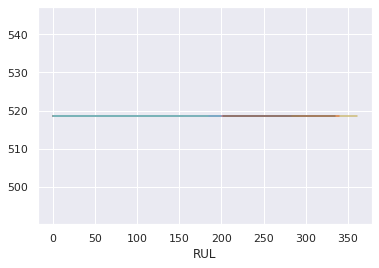

Sensor s_2


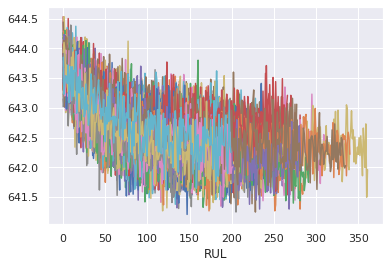

Sensor s_3


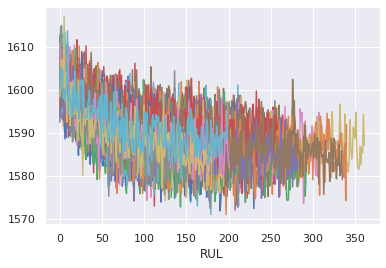

Sensor s_4


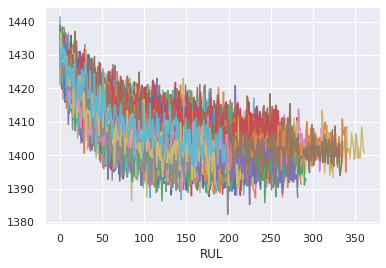

Sensor s_5


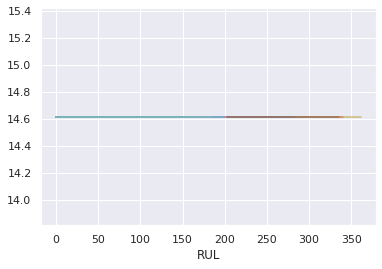

Sensor s_6


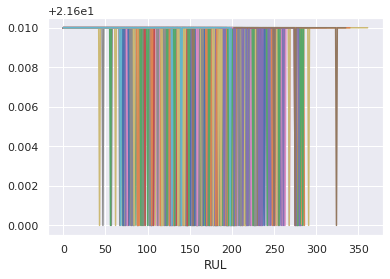

Sensor s_7


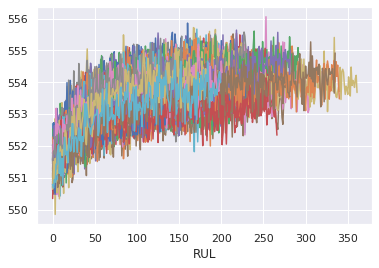

Sensor s_8


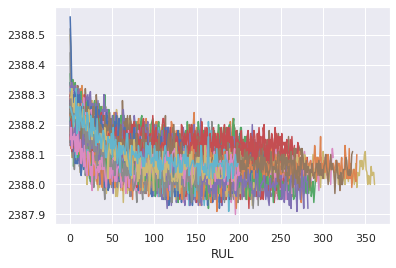

Sensor s_9


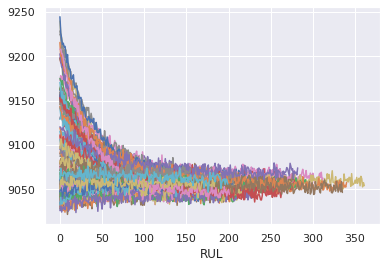

Sensor s_10


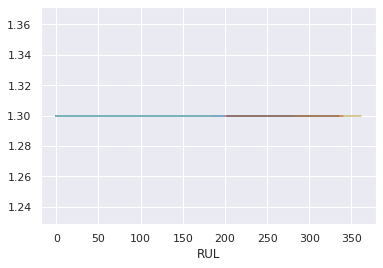

Sensor s_11


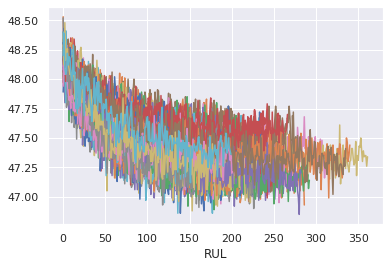

Sensor s_12


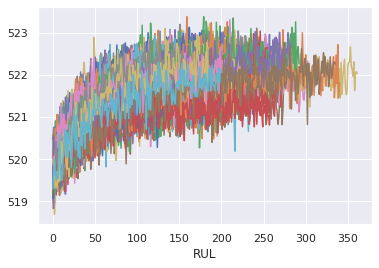

Sensor s_13


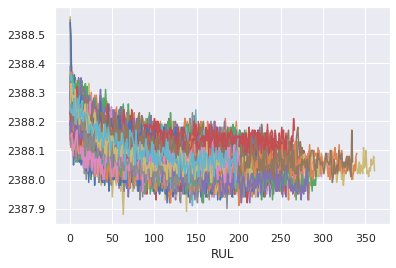

Sensor s_14


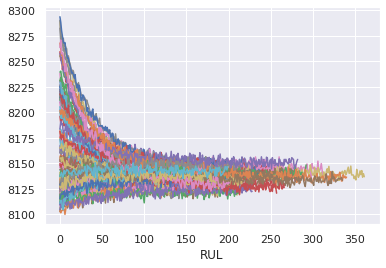

Sensor s_15


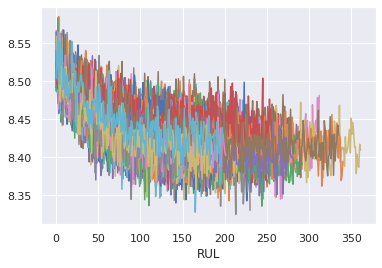

Sensor s_16


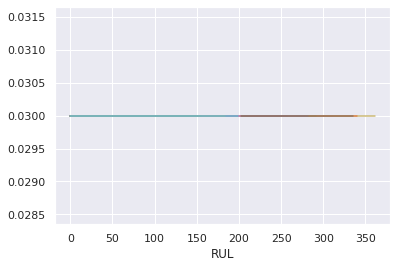

Sensor s_17


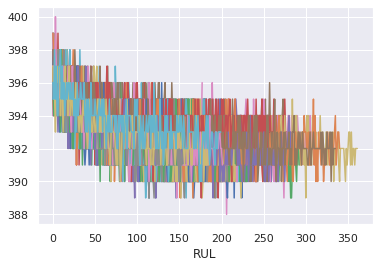

Sensor s_18


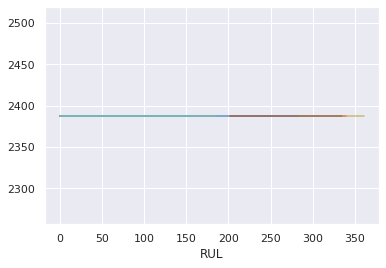

Sensor s_19


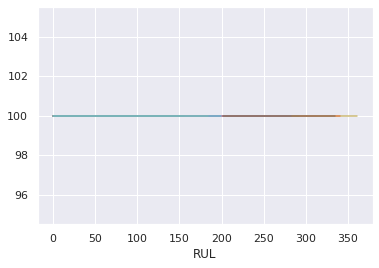

Sensor s_20


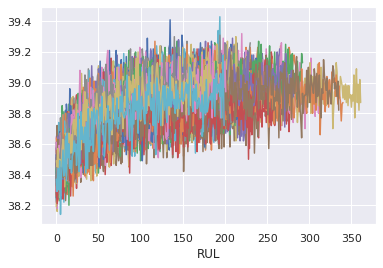

Sensor s_21


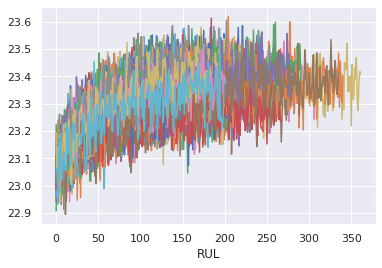

In [17]:
def plot_sensor(n_sen,data):
  for i in range(1,101):
    plt.plot(data[data['unit_nr'] == i]['RUL'],data[data['unit_nr'] == i][n_sen])
  plt.xlabel('RUL')
  plt.show()

for i in sensors_name:
  print('Sensor ' + i)
  plot_sensor(i,train)

Sensor s_5


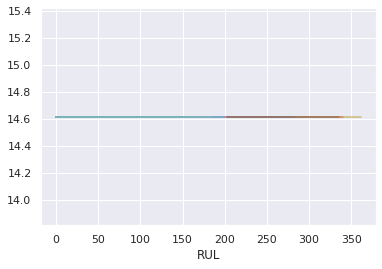

Sensor s_6


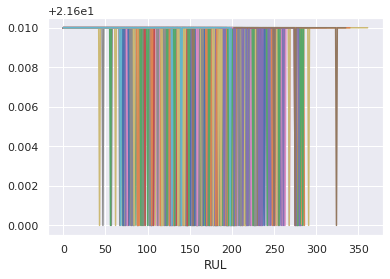

Sensor s_16


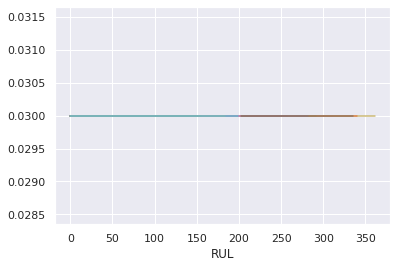

In [18]:
name = ['s_5','s_6','s_16']
for i in name:
  print('Sensor ' + i)
  plot_sensor(i,train)

There are some sensors which don't contribute a lot in the RUL -> we drop these sensors

In [19]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
drop_columns = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19','unit_nr','time_cycles', 'setting_1', 'setting_2', 'setting_3', 'RUL']
# 'time_cycles', 'setting_1', 'setting_2', 'setting_3',

**Window Function**

In [20]:
def window(train, n_engines, drop_columns,window_size = 4):
  windows = []
  targets = []
  for i in n_engines:
    data = train[train['unit_nr'] == i]
    engine_train = data.drop(columns = drop_columns).values
    engine_target = data['RUL'].values
    for i in range(len(engine_train)-window_size):
      windows.append(engine_train[i:i+window_size])
      targets.append(engine_target[i+window_size])
    data = []
    engine_train = []
    engine_target = []
  return np.asarray(windows), np.asarray(targets)

In [21]:
data = normalized_train[normalized_train['unit_nr'] == 1]
engine_train = data.drop(columns = drop_columns)
engine_target = data['RUL'].values


print(engine_train)
print(engine_train.values)

          s_2       s_3       s_4       s_7       s_8       s_9      s_11  \
0    0.183735  0.406802  0.309757  0.726248  0.242424  0.109755  0.369048   
1    0.283133  0.453019  0.352633  0.628019  0.212121  0.100242  0.380952   
2    0.343373  0.369523  0.370527  0.710145  0.272727  0.140043  0.250000   
3    0.343373  0.256159  0.331195  0.740741  0.318182  0.124518  0.166667   
4    0.349398  0.257467  0.404625  0.668277  0.242424  0.149960  0.255952   
..        ...       ...       ...       ...       ...       ...       ...   
187  0.765060  0.683235  0.684166  0.336554  0.621212  0.072602  0.684524   
188  0.894578  0.547853  0.772451  0.136876  0.560606  0.102396  0.732143   
189  0.731928  0.614345  0.737677  0.231884  0.590909  0.084582  0.880952   
190  0.641566  0.682799  0.734639  0.172303  0.575758  0.094364  0.773810   
191  0.701807  0.662089  0.758778  0.225443  0.636364  0.051557  0.833333   

         s_12      s_13      s_14      s_15      s_17      s_20      s_21  

In [22]:
print(ws_test[ws_test['unit_nr'] == 8])
print(normalized_train)

     unit_nr  time_cycles  setting_1  setting_2  setting_3  s_1       s_2  \
675        8     0.000000   0.327586   0.666667        0.0  0.0  0.334337   
676        8     0.002770   0.517241   0.416667        0.0  0.0  0.427711   
677        8     0.005540   0.482759   0.416667        0.0  0.0  0.225904   
678        8     0.008310   0.683908   0.666667        0.0  0.0  0.554217   
679        8     0.011080   0.545977   0.916667        0.0  0.0  0.243976   
..       ...          ...        ...        ...        ...  ...       ...   
836        8     0.445983   0.459770   0.916667        0.0  0.0  0.515060   
837        8     0.448753   0.609195   0.333333        0.0  0.0  0.527108   
838        8     0.451524   0.482759   0.833333        0.0  0.0  0.451807   
839        8     0.454294   0.500000   0.666667        0.0  0.0  0.620482   
840        8     0.457064   0.591954   0.083333        0.0  0.0  0.415663   

          s_3       s_4  s_5  ...      s_13      s_14      s_15  s_16  \
67

# **Applying the window function to create train_data, target_data**

In [23]:
# Creating train data and target data
clip_normalized_train = normalized_train.clip(upper = 125)
ws = 30
windows = []
targets = []
n_engines = np.arange(len(clip_normalized_train['unit_nr'].unique()) + 1)
windows, targets = window(clip_normalized_train,n_engines, drop_columns, window_size = ws)

#print(windows[1][88])
#print(windows[0][-1])

In [24]:
print('Shape of traing data: ' + str(windows.shape))
print('Shape of target data: ' + str(targets.shape))

Shape of traing data: (17631, 30, 14)
Shape of target data: (17631,)


In [25]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

# **MODEL**

# Creating Model

Attention Mechanism

In [26]:
class Attention_mechanism(Layer):

    def __init__(self, units=128, **kwargs):
        self.units = units
        super().__init__(**kwargs)

    def __call__(self, inputs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @return: 2D tensor with shape (batch_size, 128)
        @author: felixhao28, philipperemy.
        """
        hidden_states = inputs
        hidden_size = int(hidden_states.shape[2])
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
        score = Dot(axes=[1, 2], name='attention_score')([h_t, score_first_part])
        attention_weights = Activation('softmax', name='attention_weight')(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = Dot(axes=[1, 1], name='context_vector')([hidden_states, attention_weights])
        pre_activation = Concatenate(name='attention_output')([context_vector, h_t])
        attention_vector = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [27]:
from keras.callbacks import Callback

class stopAtLossValue(Callback):
        def on_batch_end(self, batch, logs={}):
            THR = 100 #Assign THR with the value at which you want to stop training.
            count = []
            if logs.get('loss') <= THR:
              self.model.stop_training = True

In [28]:
n_features = windows.shape[2]
n_steps = windows.shape[1]
optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm = 1)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation= 'relu', input_shape=(n_steps,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(100, activation='tanh', return_sequences = True, kernel_regularizer=l2(0), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.1)))
model.add(Dropout(0.5))
#model.add(GRU(50, activation='tanh', return_sequences = True, kernel_regularizer=l2(0), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.1)))
#model.add(Flatten())
model.add(Attention_mechanism(128))
model.add(Dense(30,activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(20,activation= 'relu'))
model.add(Dense(1))
model.compile(optimizer = optimizer, loss='mean_squared_error')

In [29]:
epochs = 50
batch_size = 256
#callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')]
callbacks = stopAtLossValue()

In [30]:
history = model.fit(windows,targets, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=1,shuffle=False, callbacks=[])

Epoch 1/50
66/66 [==============================] - 9s 86ms/step - loss: 5499.7202 - val_loss: 2509.9529
Epoch 2/50
66/66 [==============================] - 5s 78ms/step - loss: 1979.6595 - val_loss: 1743.9255
Epoch 3/50
66/66 [==============================] - 5s 77ms/step - loss: 1885.5277 - val_loss: 1767.7095
Epoch 4/50
66/66 [==============================] - 7s 104ms/step - loss: 1894.8896 - val_loss: 1753.5009
Epoch 5/50
66/66 [==============================] - 5s 77ms/step - loss: 1870.1013 - val_loss: 1765.5106
Epoch 6/50
66/66 [==============================] - 6s 91ms/step - loss: 1876.6748 - val_loss: 1747.3680
Epoch 7/50
66/66 [==============================] - 5s 77ms/step - loss: 1874.8402 - val_loss: 1753.1246
Epoch 8/50
66/66 [==============================] - 5s 77ms/step - loss: 1868.4240 - val_loss: 1753.5431
Epoch 9/50
66/66 [==============================] - 5s 76ms/step - loss: 1320.0590 - val_loss: 494.2679
Epoch 10/50
66/66 [==============================] - 5s

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            2752      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 14, 100)           49800     
                                                                 
 dropout (Dropout)           (None, 14, 100)           0         
                                                                 
 last_hidden_state (Lambda)  (None, 100)               0         
                                                                 
 attention_score_vec (Dense)  (None, 14, 100)          10000     
                                                        

In [32]:
#Predicting the data
y_train_pred = model.predict(windows)
evaluate(y_train_pred,targets,'train')
#evaluate(y_pred,y_test,'test')


train set RMSE:13.431073925234658, R2:0.8929843482483381


In [33]:
X_test_unit,y_test_unit = window(ws_test[ws_test['unit_nr'] == 3],n_engines,drop_columns,ws)
print(len(ws_test[ws_test['unit_nr'] == 3]))
#print(X_test_unit.shape)
#print(X_test_unit)
last_window = X_test_unit[-1].reshape(1,30,14)

print(model.predict(last_window))
print((model.predict(X_test_unit))[-1])
print(y_target.iloc[2])
print(y_target)
last_window[0][0]

126
[[51.861927]]
[51.861923]
RUL    69
Name: 2, dtype: int64
    RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]


array([0.48795181, 0.38630913, 0.40226199, 0.49597424, 0.37878788,
       0.14336355, 0.46428571, 0.56503198, 0.44117647, 0.16400041,
       0.47787611, 0.5       , 0.48837209, 0.61350456])

**Metrics and Visualization**

In [34]:
result_pred = []
result_true = []
clip_ws_test = ws_test
clip_y_target = y_target.clip(upper = 125)
for i in n_test_unit:
  X_test_unit,y_test_unit = window(clip_ws_test[clip_ws_test['unit_nr'] == i],n_engines,drop_columns,ws)
  result_pred.append(model.predict(X_test_unit)[-1])
  result_true.append(clip_y_target.iloc[i-1])
evaluate(result_true,result_pred,'test')


test set RMSE:15.924785228941918, R2:0.8422600871591078


In [35]:
before = []
after = []
for i in n_test_unit:
  before.append(y_target.iloc[i-1])
  after.append(clip_y_target.iloc[i-1])
ratio = np.array(before)/np.array(after)
print(len(ratio))
print(len(result_pred))
print(evaluate(np.array(result_true),result_pred*ratio,'test'))

99
99
test set RMSE:15.926135120183876, R2:0.8422333438469001
None


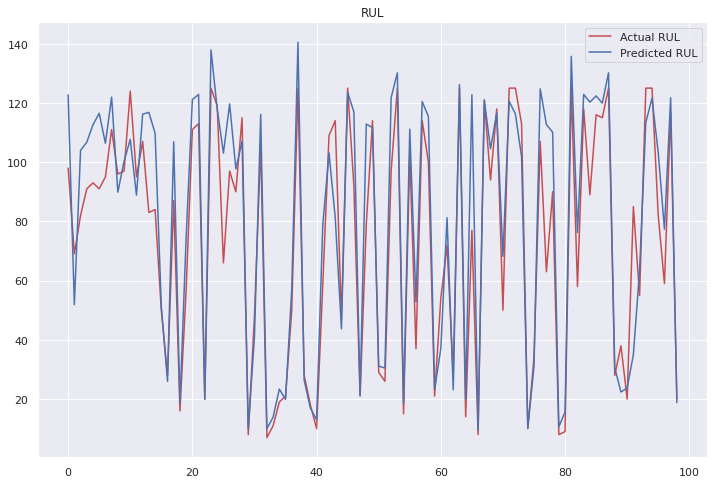

In [36]:
plt.figure(figsize=(12,8))
plt.plot(np.asarray(result_true).reshape(-1),'r', label = 'Actual RUL')
plt.plot(np.asarray(result_pred*ratio).reshape(-1),'b', label = 'Predicted RUL')
plt.legend()
plt.title('RUL')
plt.show() 

In [37]:
model.save("my_h5_model.h5")